In [1]:
from utils import get_hyperedges, get_data, get_H, check_feasibility
from model import CustomLossBatch
from LinSATNet import linsat_layer_modified
from model import utility_fn

# Pyomo Solver

In [2]:
# from pyomo.environ import (
#     ConcreteModel, Var, Objective, ConstraintList, SolverFactory, NonNegativeReals, Binary, maximize
# )
# # Step 2: Create Pyomo model
# model = ConcreteModel()

# # Step 3: Define binary decision variables for each link (b_i)
# model.b = Var(range(V_H), domain=Binary)  # b[i] = 1 if link i is active, 0 otherwise

# # Step 4: Define the objective function (maximize throughput)
# def throughput(model):
#     total_throughput = 0
#     for i in range(V_H):
#         interference = sum(model.b[j] * I[i, j] for j in range(V_H) if j != i)  # Interference from other active links
#         denominator = N[i] + interference  # Noise + interference
#         total_throughput += (I[i,i] * model.b[i]) / denominator  # Contribution of link i to throughput
#     return total_throughput

# model.obj = Objective(rule=throughput, sense=maximize)

# # Step 5: Add constraints for hyperedges (each hyperedge has a threshold)
# model.constraints = ConstraintList()

# for e_idx, hyperedge in enumerate(hyperedges):
#     model.constraints.add(
#         sum(model.b[i] for i in hyperedge) <= len(hyperedge)-1
#     )

# # Step 6: Solve the model
# solver = SolverFactory('ipopt')  # Use Ipopt for nonlinear problems
# result = solver.solve(model, tee=True)

# # Step 7: Extract the results
# optimal_decisions = [model.b[i].value for i in range(V_H)]

# # Output the optimal link schedule
# print("Optimal link schedule:", optimal_decisions)
# print("Maximum throughput:", model.obj())

# Generate data

In [105]:
import numpy as np

# Step 1: Define problem parameters
V_H = 10  # Number of nodes (links)
E_H = 5   # Number of hyperedges
N = 0.1  # Noise power
theta = 0.5  # Thresholds for hyperedges
k = 4  # max hyperedge cardinality
train_samples = 10000
test_samples = 100
batch_size = 100


In [106]:
itens_train, hlist_train = get_data(train_samples, V_H, N, theta, k)
itens_test, hlist_test = get_data(test_samples, V_H, N, theta, k)
H_train = get_H(hlist_train, V_H, train_samples)
H_test = get_H(hlist_test, V_H, test_samples)

# Exhaustive Search Solver

In [107]:
# exhaustive search
def exh_solver(V_H, E_H, N, I, hyperedges):
    best_throughput = 0
    best_schedule = None
    for i in range(2**V_H):
        schedule = [int(x) for x in bin(i)[2:].zfill(V_H)]
        throughput = 0

        # check if the schedule satisfies the hyperedge constraints
        valid_schedule = True
        for hyperedge in hyperedges:
            if sum(schedule[j] for j in hyperedge) == len(hyperedge):
                valid_schedule = False
                break
        
        if not valid_schedule:
            continue
        # calculate throughput
        for i in range(V_H):
            interference = sum(schedule[j] * I[i, j] for j in range(V_H) if j != i)
            denominator = N[i] + interference
            throughput += (I[i,i] * schedule[i]) / denominator
        
        if throughput > best_throughput:
            best_throughput = throughput
            best_schedule = schedule

    return best_throughput, best_schedule
        

In [108]:
best_throughput_test = []
for I, hyperedges in zip(itens_test, hlist_test):
    best_throughput, best_schedule = exh_solver(V_H, E_H, V_H*[N], I, hyperedges)
    best_throughput_test.append(best_throughput)
    print("Exhaustive search results:")
    print("Optimal link schedule:", best_schedule)
    print("Maximum throughput:", best_throughput)
print(f"Mean average throughput: {np.mean(best_throughput_test)}")

Exhaustive search results:
Optimal link schedule: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Maximum throughput: 7.226458646448999
Exhaustive search results:
Optimal link schedule: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Maximum throughput: 8.538285590105312
Exhaustive search results:
Optimal link schedule: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
Maximum throughput: 9.44807904401771
Exhaustive search results:
Optimal link schedule: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Maximum throughput: 9.688127907472804
Exhaustive search results:
Optimal link schedule: [0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
Maximum throughput: 9.430331871776247
Exhaustive search results:
Optimal link schedule: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Maximum throughput: 6.524916796226012
Exhaustive search results:
Optimal link schedule: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Maximum throughput: 9.541208294471847
Exhaustive search results:
Optimal link schedule: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Maximum throughput: 8.422652351286915
Exhaustive search results:
Optimal link schedule:

# Learning-Based

In [109]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data Preparation

Format of Data Should be as follows
Dictionary Keys: "$n$": Number of hypernodes ($|\mathcal{V}_H|$), "$E$": dictionray of hyperedges, "$I \in R^{n\times n}$": Interference and Power matrix, "$H \in \{0,1\}^{n\times m}$: Incident matrix ($m$ is the size of hyperedges) 

In [110]:
def hypergraph_generation(V_H, I, hyperedges):
    hypergraph = {}

    

    hypergraph["I"] = torch.DoubleTensor(I)


    H = torch.DoubleTensor(hyperedges)
    Dv_inv = torch.diag(H.sum(0)**(-1/2))
    De_inv = torch.diag(H.sum(1)**(-1))
    W = torch.eye(V_H, dtype=torch.float64)
    hypergraph["H"] = H
    hypergraph["Dv_inv"] = Dv_inv
    hypergraph["De_inv"] = De_inv
    hypergraph["W"] = W
    return hypergraph

## HyperDataset

In [111]:
from torch.utils.data import Dataset, DataLoader

class HyperDataset(Dataset):
    def __init__(self, I, Dv_inv, De_inv, H, W):
        self.I = I
        self.Dv_inv = Dv_inv
        self.De_inv = De_inv
        self.H = H
        self.W = W

    def __len__(self):
        return len(self.I)

    def __getitem__(self, idx):
        return self.I[idx], self.Dv_inv[idx], self.De_inv[idx], self.H[idx], self.W[idx]


### Generating train and test dataste

In [112]:
hyps_train, hyps_test = [], []

Is = torch.zeros((len(itens_train), V_H, V_H), dtype=torch.float64)
Dv_invs = torch.zeros((len(itens_train), V_H, V_H), dtype=torch.float64)
De_invs = torch.zeros((len(itens_train), V_H, V_H), dtype=torch.float64)
Hs = torch.zeros((len(itens_train), V_H, V_H), dtype=torch.float64)
Ws = torch.zeros((len(itens_train), V_H, V_H), dtype=torch.float64)

i = 0
for I, hyperedges in zip(itens_train, H_train):
    hyp = hypergraph_generation(V_H, I, hyperedges)
    Is[i] = hyp["I"]
    Dv_invs[i] = hyp["Dv_inv"]
    De_invs[i] = hyp["De_inv"]
    Hs[i] = hyp["H"]
    Ws[i] = hyp["W"]
    i += 1

train_dataset = HyperDataset(Is, Dv_invs, De_invs, Hs, Ws)

Is = torch.zeros((len(itens_test), V_H, V_H), dtype=torch.float64)
Dv_invs = torch.zeros((len(itens_test), V_H, V_H), dtype=torch.float64)
De_invs = torch.zeros((len(itens_test), V_H, V_H), dtype=torch.float64)
Hs = torch.zeros((len(itens_test), V_H, V_H), dtype=torch.float64)
Ws = torch.zeros((len(itens_test), V_H, V_H), dtype=torch.float64)

i = 0
for I, hyperedges in zip(itens_test, H_test):
    hyp = hypergraph_generation(V_H, I, hyperedges)
    Is[i] = hyp["I"]
    Dv_invs[i] = hyp["Dv_inv"]
    De_invs[i] = hyp["De_inv"]
    Hs[i] = hyp["H"]
    Ws[i] = hyp["W"]
    i += 1

test_dataset = HyperDataset(Is, Dv_invs, De_invs, Hs, Ws)
    

### Defining Train Loader

In [113]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training HyperGCN

In [88]:
import importlib, model, networks, utils
importlib.reload(networks)
importlib.reload(utils)

importlib.reload(model)

<module 'model' from '/Users/rezaramezanpour/Downloads/hyp-sched-main-2/model.py'>

<span style="color:red">**HyperGCN**</span> is defined in <span style="color:cyan">**networks**</span> file, but it's core layer <span style="color:red">*HyperGraphConvolution*</span> is defined in <span style="color:cyan">**utils**</span>.<br /> If you want change the entire model you can put your model in <span style="color:cyan">**networks**</span> file.<br />
The training process is defined in the <span style="color:cyan">**model**</span> file, so if you defined a new model and want to use it in training process, please change that file.<br /> Also the <span style="color:red">**Gumbel+LinSatNet**</span> is defined in <span style="color:cyan">**utils**</span> but it is used in training process. Our custom loss function (negative of our objecive) is defined in <span style="color:cyan">**model**</span>, i double checked it with random inputs, so it should be fine.

In [95]:
import model
HyperGCN = model.initialise(hyp)


In [ ]:
epochs = 500
HyperGCN = model.train(HyperGCN, hyp, epochs)

# Training HGNN

In [114]:
def get_learnable_parameters(V_H, device):
    hidden_dim = [15, 15, 1]  # 3 layers
    theta_1 = torch.empty(V_H, hidden_dim[0], dtype=torch.float64, requires_grad=True, device=device)
    torch.nn.init.xavier_uniform_(theta_1)
    theta_2 = torch.empty(hidden_dim[0], hidden_dim[1], dtype=torch.float64, requires_grad=True, device=device)
    torch.nn.init.xavier_uniform_(theta_2)
    theta_3 = torch.empty(hidden_dim[1], hidden_dim[2], dtype=torch.float64, requires_grad=True, device=device)
    torch.nn.init.xavier_uniform_(theta_3)
    theta_HGNN = [theta_1, theta_2, theta_3]
    return theta_HGNN

In [115]:
def HGNN(X, Dv_inv, De_inv, H, W, theta, batch_norm=False):
    theta_1, theta_2, theta_3 = theta
    Xbar1 = Dv_inv @ H @ W @ De_inv @ H.transpose(1, 2) @ Dv_inv @ X @ theta_1.unsqueeze(0)
    X1 = torch.nn.functional.relu(Xbar1)
    if batch_norm:
        X1 = (X1 - torch.mean(X1, dim=0))/torch.sqrt(torch.var(X1, dim=0) + 1e-5)
    Xbar2 = Dv_inv @ H @ W @ De_inv @ H.transpose(1, 2) @ Dv_inv @ X1 @ theta_2.unsqueeze(0)
    X2 = torch.nn.functional.relu(Xbar2)
    if batch_norm:
        X2 = (X2 - torch.mean(X2, dim=0))/torch.sqrt(torch.var(X2, dim=0) + 1e-5)
    Xbar3 = Dv_inv @ H @ W @ De_inv @ H.transpose(1, 2) @ Dv_inv @ X2 @ theta_3.unsqueeze(0)
    X3 = torch.nn.functional.sigmoid(Xbar3)
    X3 = X3.squeeze()
    return X3

# Training

In [132]:
theta_HGNN = get_learnable_parameters(V_H, device)
# optimizer = torch.optim.Adam(theta_HGNN, lr=0.1)
optimizer = torch.optim.SGD(theta_HGNN, lr=0.01)

loss_fn = CustomLossBatch()

In [133]:
beta = 1
tau = 5
max_iter = 1000
epochs = 1000
batch_norm=True
train_utility, test_utility = [], []
optimizer.zero_grad()
for epoch in range(epochs):
    # Train Phase
    loss_epoch, utility_epoch, feasibility_epoch = [], [], []
    for (X, Dv_inv, De_inv, H, W) in train_loader:
        X, H, W = X.to(device), H.to(device), W.to(device)
        Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)
        z = HGNN(X, Dv_inv, De_inv, H, W, theta_HGNN, batch_norm)
        # Linsat
        z = z * beta
        RHS_const = H.transpose(2, 1).sum(dim=2) - 1
        LHS_const = H.transpose(2, 1)
        z = linsat_layer_modified(z.float(), A=LHS_const.float(), b=RHS_const.float(), tau=tau, max_iter=max_iter, dummy_val=0, no_warning=False, grouped=False).double()
        z = z / beta
        loss = loss_fn(z, X, N, gamma=0.0)[0]
        utility = utility_fn(z, X, N)  # utility based on discrete values of z
        feasibility = check_feasibility(H, z)
        utility_epoch.append(utility.item()/batch_size)
        feasibility_epoch.append(feasibility)
        loss.backward()
        # print(torch.linalg.matrix_norm(theta_HGNN[0].grad))
        optimizer.step()
        optimizer.zero_grad()
        loss_epoch.append(loss.item())
    # Test Phase
    utility_epoch_test, feasibility_epoch_test = [], []
    for (X, Dv_inv, De_inv, H, W) in test_loader:
        X, H, W = X.to(device), H.to(device), W.to(device)
        Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)
        z = HGNN(X, Dv_inv, De_inv, H, W, theta_HGNN, batch_norm)
        # Linsat 
        z = z * beta
        RHS_const = H.transpose(2, 1).sum(dim=2) - 1
        LHS_const = H.transpose(2, 1)
        z = linsat_layer_modified(z.float(), A=LHS_const.float(), b=RHS_const.float(), tau=tau, max_iter=max_iter, dummy_val=0, no_warning=False, grouped=False).double()
        z = z / beta
        utility = utility_fn(z, X, N)  # utility based on discrete values of z
        feasibility = check_feasibility(H, z)
        utility_epoch_test.append(utility.item()/batch_size)
        feasibility_epoch_test.append(feasibility)
    utility_epoch_mean = np.mean(utility_epoch)
    utility_epoch_test_mean = np.mean(utility_epoch_test)
    feasibility_epoch_mean = np.mean(feasibility_epoch)
    feasibility_epoch_test_mean = np.mean(feasibility_epoch_test)
    print(z[0])
    if epoch % 1 == 0:
        print(f"Epoch: {epoch}, Loss:{np.mean(loss_epoch):.5f} | Train Utility: {utility_epoch_mean:.5f}, Feasibility: {feasibility_epoch_mean:.2f}" \
        f" | Test Utility: {utility_epoch_test_mean:.5f}, Feasibility: {feasibility_epoch_test_mean:.2f}")
    train_utility.append(utility_epoch_mean)
    test_utility.append(utility_epoch_test_mean)
print(f"Final utility per hypergraph: {utility_epoch_test}")

tensor([0.3533, 0.5178, 0.3963, 0.3692, 0.2899, 0.2787, 0.2889, 0.3901, 0.4887,
        0.4831], device='cuda:0', dtype=torch.float64,
       grad_fn=<SelectBackward0>)
Epoch: 0, Loss:-66.67801 | Train Utility: 0.93113, Feasibility: 1.00 | Test Utility: 0.92265, Feasibility: 1.00
tensor([0.3533, 0.5170, 0.3961, 0.3668, 0.2895, 0.2788, 0.2892, 0.3899, 0.4889,
        0.4830], device='cuda:0', dtype=torch.float64,
       grad_fn=<SelectBackward0>)
Epoch: 1, Loss:-66.68979 | Train Utility: 0.91409, Feasibility: 1.00 | Test Utility: 0.85308, Feasibility: 1.00
tensor([0.3530, 0.5114, 0.3965, 0.3647, 0.2824, 0.2788, 0.2924, 0.3851, 0.4881,
        0.4832], device='cuda:0', dtype=torch.float64,
       grad_fn=<SelectBackward0>)
Epoch: 2, Loss:-66.69960 | Train Utility: 0.89982, Feasibility: 1.00 | Test Utility: 0.81458, Feasibility: 1.00
tensor([0.3416, 0.5005, 0.3931, 0.3587, 0.2853, 0.2832, 0.2940, 0.3761, 0.4878,
        0.4808], device='cuda:0', dtype=torch.float64,
       grad_fn=<Select

KeyboardInterrupt: 

In [119]:
import matplotlib.pyplot as plt

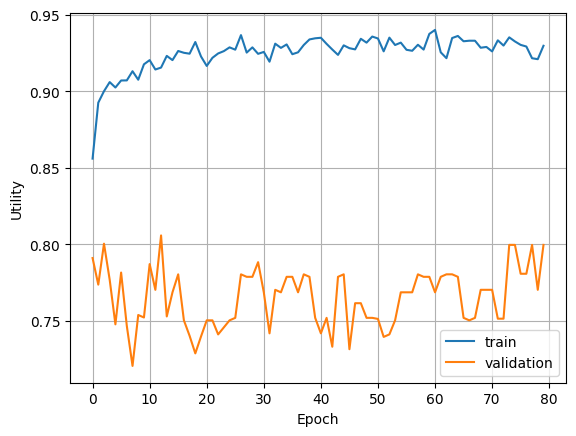

In [123]:
plt.plot(train_utility, label='train')
plt.plot(test_utility, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Utility')
plt.grid()
plt.legend()
# plt.savefig('HGNN_train_batch_norm.jpg')

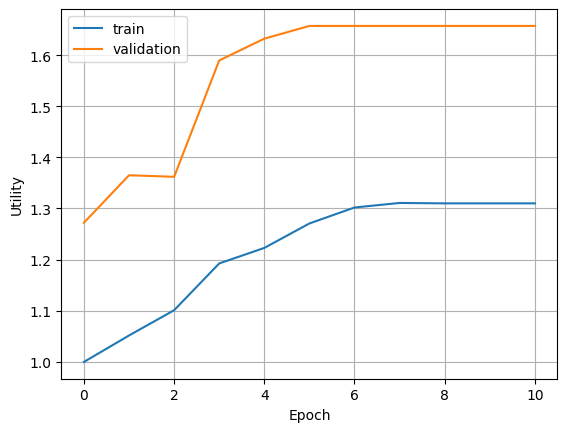

In [204]:
plt.plot(torch.stack(train_utility).detach().numpy(), label='train')
plt.plot(torch.stack(test_utility).detach().numpy(), label='validation')
plt.xlabel('Epoch')
plt.ylabel('Utility')
plt.grid()
plt.legend()
# plt.savefig('HGNN_train_reg0.5.jpg')

In [238]:
Z

tensor([[0.4464],
        [0.4477],
        [0.4607],
        [0.4284],
        [0.4309],
        [0.4087],
        [0.4464],
        [0.4238],
        [0.4166],
        [0.4267]], dtype=torch.float64, grad_fn=<SigmoidBackward0>)

In [138]:
loss_fn(Z, X, N)

(tensor(-8.7234, dtype=torch.float64, grad_fn=<NegBackward0>),
 tensor(8.7234, dtype=torch.float64, grad_fn=<SumBackward0>))

In [139]:
exh_solver(V_H, None, V_H*[N], X, list(hyp['E'].values()))

(tensor(9.7985, dtype=torch.float64), [0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

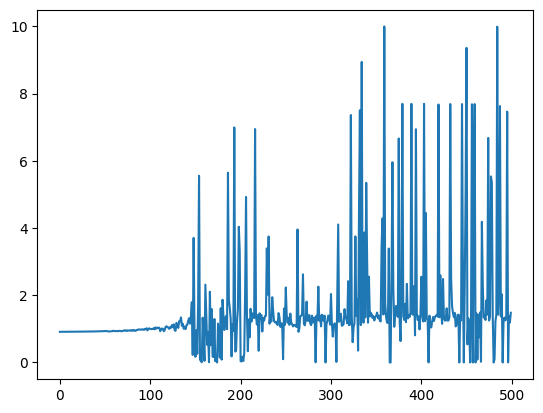

In [16]:
plt.plot(torch.stack(HyperGCN['utility']).detach().numpy())